<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/main/GAN_MAML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 49.2 MB/s eta 0:00:00
Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.75MB/s]



Starting True Second-Order MAML Training...

[Epoch 1/40] D_meta_loss: 0.3548, G_meta_loss: 1.7671
[Epoch 2/40] D_meta_loss: 0.3432, G_meta_loss: 1.7708
[Epoch 3/40] D_meta_loss: 0.3658, G_meta_loss: 1.5782
[Epoch 4/40] D_meta_loss: 0.4735, G_meta_loss: 1.1462
[Epoch 5/40] D_meta_loss: 0.8074, G_meta_loss: 0.6475
[Epoch 6/40] D_meta_loss: 0.5723, G_meta_loss: 0.9905
[Epoch 7/40] D_meta_loss: 0.6049, G_meta_loss: 0.9383
[Epoch 8/40] D_meta_loss: 0.7868, G_meta_loss: 0.6722
[Epoch 9/40] D_meta_loss: 1.0346, G_meta_loss: 0.4731
[Epoch 10/40] D_meta_loss: 0.5654, G_meta_loss: 1.0132
[Epoch 11/40] D_meta_loss: 0.6032, G_meta_loss: 0.8775
[Epoch 12/40] D_meta_loss: 0.7921, G_meta_loss: 0.6691
[Epoch 13/40] D_meta_loss: 0.7060, G_meta_loss: 0.7348
[Epoch 14/40] D_meta_loss: 0.7182, G_meta_loss: 0.7209
[Epoch 15/40] D_meta_loss: 0.7328, G_meta_loss: 0.6996
[Epoch 16/40] D_meta_loss: 0.7308, G_meta_loss: 0.7030
[Epoch 17/40] D_meta_loss: 0.6739, G_meta_loss: 0.7770
[Epoch 18/40] D_meta_loss: 0

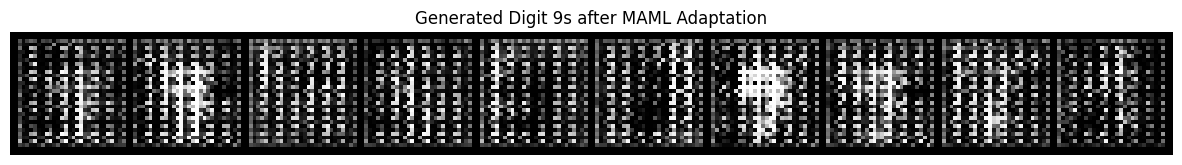

ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [ ]:
# ✅ Install dependencies
!pip install torch torchvision matplotlib tqdm torchmetrics higher --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random, os, higher
from copy import deepcopy

# Metrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# Generator (DCGAN style CNN)
# -------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

# -------------------------------
# Discriminator (DCGAN style CNN)
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

# -------------------------------
# Load MNIST
# -------------------------------
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

def get_digit_indices(dataset, digit, max_samples=None):
    idx = [i for i, (_, y) in enumerate(dataset) if y == digit]
    if max_samples:
        idx = idx[:max_samples]
    return idx

# -------------------------------
# Training Parameters
# -------------------------------
z_dim = 100
inner_steps = 5
inner_lr = 0.005
outer_lr = 0.0002
meta_epochs = 40
support_size_train = 128
support_size_test = 32

# Meta models
metaG = Generator(z_dim).to(device)
metaD = Discriminator().to(device)
meta_optimizer = optim.Adam(
    list(metaG.parameters()) + list(metaD.parameters()),
    lr=outer_lr, betas=(0.0, 0.9)
)
loss_fn = nn.BCELoss()

# -------------------------------
# Meta-training on digits 0–8
# -------------------------------
print("\nStarting True Second-Order MAML Training...\n")

for epoch in range(meta_epochs):
    g_meta_loss, d_meta_loss = 0, 0
    meta_optimizer.zero_grad()

    for digit in range(9):  # digits 0–8
        support_idx = get_digit_indices(train_dataset, digit, support_size_train)
        query_idx = get_digit_indices(test_dataset, digit, 64)

        support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_train)
        query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

        x_support, _ = next(iter(support_loader))
        x_query, _ = next(iter(query_loader))
        x_support, x_query = x_support.to(device), x_query.to(device)

        # Inner loop with higher
        inner_optG = optim.SGD(metaG.parameters(), lr=inner_lr)
        inner_optD = optim.SGD(metaD.parameters(), lr=inner_lr)

        with higher.innerloop_ctx(metaG, inner_optG, copy_initial_weights=False) as (fG, diff_optG), \
             higher.innerloop_ctx(metaD, inner_optD, copy_initial_weights=False) as (fD, diff_optD):

            for step in range(inner_steps):
                z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
                fake = fG(z)
                real = x_support

                # Train D
                real_labels = torch.full((real.size(0),), 0.9, device=device)  # real = 0.9
                fake_labels = torch.full((fake.size(0),), 0.1, device=device)  # fake = 0.1
                d_real = fD(real)
                d_fake = fD(fake.detach())
                d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
                diff_optD.step(d_loss)

                # Train G
                z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
                fake = fG(z)
                g_fake = fD(fake)
                g_loss = loss_fn(g_fake, torch.ones_like(g_fake))
                diff_optG.step(g_loss)

            # Query loss after adaptation
            z_q = torch.randn(len(x_query), z_dim, 1, 1).to(device)
            fake_q = fG(z_q)
            d_real_q = fD(x_query)
            d_fake_q = fD(fake_q)
            d_q_loss = loss_fn(d_real_q, torch.ones_like(d_real_q)) + \
                       loss_fn(d_fake_q, torch.zeros_like(d_fake_q))
            g_q_loss = loss_fn(fD(fake_q), torch.ones_like(d_fake_q))

            # Accumulate meta gradients (second-order!)
            (d_q_loss + g_q_loss).backward()

            d_meta_loss += d_q_loss.item()
            g_meta_loss += g_q_loss.item()

    meta_optimizer.step()
    print(f"[Epoch {epoch+1}/{meta_epochs}] D_meta_loss: {d_meta_loss/9:.4f}, G_meta_loss: {g_meta_loss/9:.4f}")

# -------------------------------
# Meta-testing on digit 9
# -------------------------------
print("\nMeta-testing on digit 9...\n")
support_idx = get_digit_indices(train_dataset, 9, support_size_test)
query_idx = get_digit_indices(test_dataset, 9, 64)

support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_test)
query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

x_support, _ = next(iter(support_loader))
x_query, _ = next(iter(query_loader))
x_support, x_query = x_support.to(device), x_query.to(device)

# Adapt meta-trained models to digit 9
G = deepcopy(metaG)
D = deepcopy(metaD)
optG = optim.Adam(G.parameters(), lr=inner_lr, betas=(0.0, 0.9))
optD = optim.Adam(D.parameters(), lr=inner_lr, betas=(0.0, 0.9))

for step in range(15):
    z = torch.randn(support_size_test, z_dim, 1, 1).to(device)
    fake = G(z)
    real = x_support
    d_real = D(real)
    d_fake = D(fake.detach())
    d_loss = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))

    optD.zero_grad()
    d_loss.backward()
    optD.step()

    fake = G(z)
    g_loss = loss_fn(D(fake), torch.ones_like(D(fake)))
    optG.zero_grad()
    g_loss.backward()
    optG.step()

    print(f"Adapt Step {step+1}/{inner_steps} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

# -------------------------------
# Generate Digit 9 Samples
# -------------------------------
G.eval()
z = torch.randn(10, z_dim, 1, 1).to(device)
samples = G(z).cpu().detach()
grid = vutils.make_grid(samples, nrow=10, normalize=True)
plt.figure(figsize=(15,3))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Generated Digit 9s after MAML Adaptation")
plt.show()

# -------------------------------
# Evaluation Metrics
# -------------------------------
fid = FrechetInceptionDistance(feature=64).to(device)
kid = KernelInceptionDistance(subset_size=50).to(device)
is_metric = InceptionScore().to(device)

fid.update(samples.to(device), real=False)
fid.update(x_query.to(device), real=True)
print("FID:", fid.compute().item())

kid.update(samples.to(device), real=False)
kid.update(x_query.to(device), real=True)
print("KID:", kid.compute()[0].item())

is_metric.update(samples.to(device))
print("Inception Score:", is_metric.compute()[0].item())